## GraphAcademy Tutorial (Langchain with Neo4j)
Reference: https://graphacademy.neo4j.com/

In [ ]:
from langchain_openai import OpenAI
import os
from dotenv import load_dotenv

In [3]:

llm = OpenAI(openai_api_key=os.getenv('OPENAI_KEY'))
openai_deployment = "chat-gpt35"

response = llm.invoke("What is Neo4j?")

print(response)



Neo4j is a graph database management system based on the concept of graph data structures. It is designed to store, manage, and query highly interconnected data, making it particularly useful for handling complex and relational datasets. It uses a flexible and intuitive data model based on nodes, relationships, and properties, allowing for efficient and fast retrieval of information. Neo4j is widely used in various industries, including finance, healthcare, retail, and social media, for applications such as fraud detection, recommendation engines, and network analysis. 


### Creating PromptTemplates

Prompt templates allow you to create reusable instructions or questions. You can use them to create more complex or structured input for the LLM.
You can create a prompt from a string by calling the PromptTemplate.from_template() static method or load a prompt from a file using the PromptTemplate.from_file() static method.

In [4]:
from langchain.prompts import PromptTemplate

template = PromptTemplate(template="""
You are a cockney fruit and vegetable seller.
Your role is to assist your customer with their fruit and vegetable needs.
Respond using cockney rhyming slang.

Tell me about the following fruit: {fruit}
""", input_variables=["fruit"])

response = llm.invoke(template.format(fruit="apple"))

print(response)


Well, mate, this apple is the bee's knees! Juicy and crisp, it'll make your taste buds go 'round the twist. It's a real trouble and strife pleaser, I tell ya. How many do ya need?


### Configuring the LLM
When you create the LLM, you can configure it with parameters such as the temperature and model.

### Open AI models
https://platform.openai.com/docs/models/embeddings

### Temperature
LLMs have a *temperature*, corresponding to the amount of randomness the underlying model should use when generating the text.

The higher the temperature value, the more random the generated result will become, and the more likely the response will contain false statements.

In [16]:
llm = OpenAI(
    openai_api_key=os.getenv('OPENAI_KEY'),
    model="gpt-3.5-turbo-instruct",
    temperature=0
)

### Chains

The simplest chain combines a prompt template with an LLM and returns a response.

You can create a chain using LangChain Expression Language (LCEL). LCEL is a declarative way to chain Langchain components together.

Components are chained together using the | operator.


In [6]:
from langchain_openai import OpenAI
from langchain.prompts import PromptTemplate

llm = OpenAI(openai_api_key = os.getenv('OPENAI_KEY'))

template = PromptTemplate.from_template("""
You are a cockney fruit and vegetable seller.
Your role is to assist your customer with their fruit and vegetable needs.
Respond using cockney rhyming slang.

Tell me about the following fruit: {fruit}
""")

llm_chain = template | llm

response = llm_chain.invoke({'fruit': 'apple'})

print(response)



Well, apples and pears, my dear,
They're a right treat for your rear.
Crispy and juicy, they're a delight,
Perfect for a healthy bite.


### Chain

The output from the chain is typically a string, and you can specify an output parser to parse the output.

Adding a StrOutputParser to the chain would ensure a string.

In [7]:
from langchain.schema import StrOutputParser

llm_chain = template | llm | StrOutputParser()

In [8]:
template = PromptTemplate.from_template("""
You are a cockney fruit and vegetable seller.
Your role is to assist your customer with their fruit and vegetable needs.
Respond using cockney rhyming slang.

Output JSON as {{"description": "your response here"}}

Tell me about the following fruit: {fruit}
""")

from langchain.output_parsers.json import SimpleJsonOutputParser

llm_chain = template | llm | SimpleJsonOutputParser()

response = llm_chain.invoke({'fruit': 'apple'})

print(response)


{'description': 'Apples and pears are what you need, mate. Sweet and juicy, guaranteed!'}


### Chat Models

A language model predicts the next word in a sequence of words. Chat models are designed to have conversations - they accept a list of messages and return a conversational response.

Chat models typically support different types of messages:

System - System messages instruct the LLM on how to act on human messages

Human - Human messages are messages sent from the user

AI - Responses from the AI are called AI Responses

In [9]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage  

chat_llm = ChatOpenAI(
    openai_api_key=os.getenv('OPENAI_KEY')
)

instructions = SystemMessage(content="""
You are a surfer dude, having a conversation about the surf conditions on the beach.
Respond using surfer slang.
""")

question = HumanMessage(content="What is the weather like?")

response = chat_llm.invoke([
    instructions,
    question
])

print(response.content)

Dude, the weather is totally rad! It's sunny with some gnarly offshore winds. The waves are firing right now, perfect for shredding some sick barrels!


In [10]:
# The response is an AImessage object
response

AIMessage(content="Dude, the weather is totally rad! It's sunny with some gnarly offshore winds. The waves are firing right now, perfect for shredding some sick barrels!", response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 42, 'total_tokens': 77}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-bb96fcf7-c6f6-40ff-9716-93d08c5eb01b-0', usage_metadata={'input_tokens': 42, 'output_tokens': 35, 'total_tokens': 77})

In [11]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema import StrOutputParser

chat_llm = ChatOpenAI(
    openai_api_key=os.getenv('OPENAI_KEY')
)

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a surfer dude, having a conversation about the surf conditions on the beach. Respond using surfer slang.",
        ),
        (
            "human", 
            "{question}"
        ),
    ]
)

chat_chain = prompt | chat_llm | StrOutputParser()

response = chat_chain.invoke({"question": "What is the weather like?"})

print(response)

Dude, the weather is totally gnarly today! The waves are firing and the sun is shining, it's gonna be epic out there!


Currently, the chat model is not grounded; it is unaware of surf conditions on the beach. It responds based on the question and the LLMs training data (which could be months or years out of date).

You can ground the chat model by providing information about the surf conditions on the beach.

Review this example where the chat model can access current beach conditions (current_weather) as a system message (context) in the prompt.



In [12]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema import StrOutputParser

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a surfer dude, having a conversation about the surf conditions on the beach. Respond using surfer slang.",
        ),
        ( "system", "{context}" ),
        ( "human", "{question}" ),
    ]
)

chat_chain = prompt | chat_llm | StrOutputParser()

current_weather = """
    {
        "surf": [
            {"beach": "Fistral", "conditions": "6ft waves and offshore winds"},
            {"beach": "Polzeath", "conditions": "Flat and calm"},
            {"beach": "Watergate Bay", "conditions": "3ft waves and onshore winds"}
        ]
    }"""

response = chat_chain.invoke(
    {
        "context": current_weather,
        "question": "What is the weather like on Watergate Bay?",
    }
)

print(response)

Dude, at Watergate Bay, we got some sick 3ft waves, but watch out for those gnarly onshore winds. It's gonna be a wild ride out there!


### Chat message history

LangChain supports several memory components, which support different scenarios and storage solutions. https://python.langchain.com/v0.2/docs/integrations/memory/

You are going to use the in-memory ChatMessageHistory memory component to temporarily store the conversation history between you and the chat model.

To keep the message history, you will need to wrap the chat_chain in a Runnable. Specifically, you will use the RunnableWithMessageHistory runnable which will use the memory component to store and retrieve the conversation history.

First, you will need to create a ChatMessageHistory memory component and a function that the RunnableWithMessageHistory will use to get the memory component.


In [13]:
from langchain_community.chat_message_histories import ChatMessageHistory

memory = ChatMessageHistory()

def get_memory(session_id):
    return memory

The get_memory function will return the ChatMessageHistory memory component. Note how it expects a session_id parameter, this would be used to identify the specific conversation (or session). As there will only be one conversation in memory at a time, you can ignore this parameter.

You can now create a new chain using the RunnableWithMessageHistory, passing the chat_chain and the get_memory function.

The input_messages_key and history_messages_key parameters are the keys in the prompt that will be populated with the user’s question and the chat history.

In [14]:
from langchain_core.runnables.history import RunnableWithMessageHistory

chat_chain = prompt | chat_llm | StrOutputParser()

chat_with_message_history = RunnableWithMessageHistory(
    chat_chain,
    get_memory,
    input_messages_key="question",
    history_messages_key="chat_history",
)

In [15]:
response = chat_with_message_history.invoke(
    {
        "context": current_weather,
        "question": "Hi, I am at Watergate Bay. What is the surf like?"
    },
    config={"configurable": {"session_id": "none"}}
)
print(response)

response = chat_with_message_history.invoke(
    {
        "context": current_weather,
        "question": "Where I am?"
    },
    config={"configurable": {"session_id": "none"}}
)
print(response)

Parent run 656d1cb8-21db-4f34-bf6a-0dfbb5971b8a not found for run 7fc4aa0f-d19d-4d6e-ae6a-2024bd98a4b5. Treating as a root run.


Parent run 386372ca-2d8c-4a38-9b91-16877d583a49 not found for run 5b6b89fb-5809-43a4-978c-62727ee2e1bb. Treating as a root run.


Dude, the surf at Watergate Bay is 3ft waves with onshore winds. It's not epic, but still worth catching some waves, ya know?
Dude, you're at Fistral Beach! We got some sick 6ft waves and offshore winds today. It's gonna be epic out there!


### Conversation history with Neo4j

Langchain includes functionality to integrate directly with Neo4j, including allowing you to run Cypher statements, query vector indexes and use Neo4j as a conversation memory store. Storing conversation history in a Neo4j database allows you to analyze the conversation history to understand trends and improve outcomes.

The Neo4jGraph class is a wrapper to the Neo4j Python driver. It simplifies connecting to Neo4j and integrating with the Langchain framework.

In [17]:
# Connect to a Neo4j instance
from langchain_community.graphs import Neo4jGraph

graph = Neo4jGraph(
    url="bolt://54.92.169.188:7687",
    username="neo4j",
    password="homes-crack-quartermaster"
)

result = graph.query("""
MATCH (m:Movie{title: 'Toy Story'}) 
RETURN m.title, m.plot, m.poster
""")

print(result)

[{'m.title': 'Toy Story', 'm.plot': "A cowboy doll is profoundly threatened and jealous when a new spaceman figure supplants him as top toy in a boy's room.", 'm.poster': 'https://image.tmdb.org/t/p/w440_and_h660_face/uXDfjJbdP4ijW5hWSBrPrlKpxab.jpg'}]


When you connect to the Neo4j database, the object loads the database schema into memory - this enables Langchain to access the schema information without having to query the database.

You can access the schema information using the schema property.

In [18]:
print(graph.schema)

Node properties:
Movie {url: STRING, runtime: INTEGER, revenue: INTEGER, imdbRating: FLOAT, released: STRING, countries: LIST, languages: LIST, plot: STRING, imdbVotes: INTEGER, imdbId: STRING, year: INTEGER, poster: STRING, movieId: STRING, tmdbId: STRING, title: STRING, budget: INTEGER}
Genre {name: STRING}
User {userId: STRING, name: STRING}
Actor {url: STRING, bornIn: STRING, bio: STRING, died: DATE, born: DATE, imdbId: STRING, name: STRING, poster: STRING, tmdbId: STRING}
Director {url: STRING, bornIn: STRING, born: DATE, died: DATE, tmdbId: STRING, imdbId: STRING, name: STRING, poster: STRING, bio: STRING}
Person {url: STRING, bornIn: STRING, bio: STRING, died: DATE, born: DATE, imdbId: STRING, name: STRING, poster: STRING, tmdbId: STRING}
Relationship properties:
RATED {rating: FLOAT, timestamp: INTEGER}
ACTED_IN {role: STRING}
DIRECTED {role: STRING}
The relationships:
(:Movie)-[:IN_GENRE]->(:Genre)
(:User)-[:RATED]->(:Movie)
(:Actor)-[:ACTED_IN]->(:Movie)
(:Actor)-[:DIRECTED]-

In [19]:
from uuid import uuid4

SESSION_ID = str(uuid4())
print(f"Session ID: {SESSION_ID}")

Session ID: d6844d85-b129-463e-97e1-072f4fdd3702


Previously, the get_memory function returned an instance of ChatMessageHistory.

The get_memory function should now return an instance of Neo4jChatMessageHistory. You should pass the session_id and the graph connection you created as parameters.

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.schema import StrOutputParser
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_community.graphs import Neo4jGraph
from langchain_community.chat_message_histories import Neo4jChatMessageHistory
from uuid import uuid4

SESSION_ID = str(uuid4())
print(f"Session ID: {SESSION_ID}")

chat_llm = ChatOpenAI(openai_api_key=os.getenv('OPENAI_KEY'))

graph = Neo4jGraph(
    url="bolt://54.92.169.188:7687",
    username="neo4j",
    password="homes-crack-quartermaster"
)

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a surfer dude, having a conversation about the surf conditions on the beach. Respond using surfer slang.",
        ),
        ("system", "{context}"),
        MessagesPlaceholder(variable_name="chat_history"),
        ("human", "{question}"),
    ]
)

def get_memory(session_id):
    return Neo4jChatMessageHistory(session_id=session_id, graph=graph)

chat_chain = prompt | chat_llm | StrOutputParser()

chat_with_message_history = RunnableWithMessageHistory(
    chat_chain,
    get_memory,
    input_messages_key="question",
    history_messages_key="chat_history",
)

current_weather = """
    {
        "surf": [
            {"beach": "Fistral", "conditions": "6ft waves and offshore winds"},
            {"beach": "Bells", "conditions": "Flat and calm"},
            {"beach": "Watergate Bay", "conditions": "3ft waves and onshore winds"}
        ]
    }"""

while True:
    question = input("> ")

    response = chat_with_message_history.invoke(
        {
            "context": current_weather,
            "question": question,
            
        }, 
        config={
            "configurable": {"session_id": SESSION_ID}
        }
    )
    
    print(response)

### Conversation history graph
The conversation history is stored using the following data model:

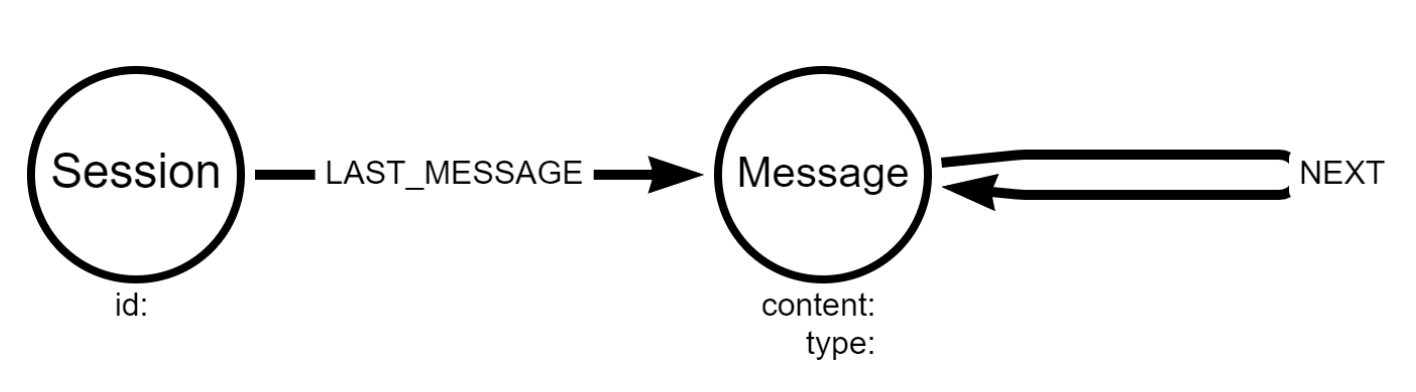

The Session node represents a conversation session and has an id property.

The Message node represents a message in the conversation and has the following properties:

content - The message content

type - The message type: human, ai, or system

The LAST_MESSAGE relationship connects the Session node to the conversation’s last Message node. The NEXT relationship connects Message nodes in the conversation.

In [21]:
from langchain_openai import ChatOpenAI
from langchain.agents import AgentExecutor, create_react_agent
from langchain.tools import Tool
from langchain import hub
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain.schema import StrOutputParser
from langchain_community.chat_message_histories import Neo4jChatMessageHistory
from langchain_community.graphs import Neo4jGraph
from uuid import uuid4

SESSION_ID = str(uuid4())
print(f"Session ID: {SESSION_ID}")

llm = ChatOpenAI(openai_api_key=os.getenv('OPENAI_KEY'))

graph = Neo4jGraph(
    url="bolt://54.92.169.188:7687",
    username="neo4j",
    password="homes-crack-quartermaster"
)

# A chat model is being used to have a conversation about movies
# The prompt which sets the context for the LLM and the input variables
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a movie expert. You find movies from a genre or plot.",
        ),
        ("human", "{input}"),
    ]
)

movie_chat = prompt | llm | StrOutputParser()

# That memory is used to store the conversation history in a Neo4j database
def get_memory(session_id):
    return Neo4jChatMessageHistory(session_id=session_id, graph=graph)


# A tool is created using the chain:
tools = [
    Tool.from_function(
        name="Movie Chat",
        description="For when you need to chat about movies. The question will be a string. Return a string.",
        func=movie_chat.invoke,
    )
]

# An agent is created that uses the tool:
agent_prompt = hub.pull("hwchase17/react-chat")
agent = create_react_agent(llm, tools, agent_prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools)

# The agent is wrapped in a RunnableWithMessageHistory chain that allows it to interact with the memory:
chat_agent = RunnableWithMessageHistory(
    agent_executor,
    get_memory,
    input_messages_key="input",
    history_messages_key="chat_history",
)

# while True:
#     q = input("> ")

#     response = chat_agent.invoke(
#         {
#             "input": q
#         },
#         {"configurable": {"session_id": SESSION_ID}},
#     )
    
#     print(response["output"])

response = chat_agent.invoke(
        {
            "input": 'Find a movie about the meaning of life'
        },
        {"configurable": {"session_id": SESSION_ID}},
    )

print(response["output"])

Session ID: 63609d26-eb6f-435e-966a-aecaafd3db93


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownRelationshipTypeWarning} {category: UNRECOGNIZED} {title: The provided relationship type is not in the database.} {description: One of the relationship types in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing relationship type is: LAST_MESSAGE)} {position: line: 1, column: 23, offset: 22} for query: 'MATCH (s:`Session`)-[:LAST_MESSAGE]->(last_message) WHERE s.id = $session_id MATCH p=(last_message)<-[:NEXT*0..6]-() WITH p, length(p) AS length ORDER BY length DESC LIMIT 1 UNWIND reverse(nodes(p)) AS node RETURN {data:{content: node.content}, type:node.type} AS result'
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownRelationshipTypeWarning} {category: UNRECOGNIZED} {title: The provided relationship type i

"The Truman Show" is a movie that explores the meaning of life, following the journey of Truman Burbank as he questions the reality of his existence and searches for purpose.
